In [1]:
plate_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1.csv"
plate_1_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1_repeat.csv"
plate_2_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_1.csv"
plate_2_2 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_2.csv"
plate_2_3 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_3.csv"
plate_2_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat.csv"
plate_2_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat _96.csv"
list_A = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA.csv"
list_A_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA_repeat.csv"
list_B = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB.csv"
list_B_repeat_end = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _end.csv"
list_B_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _96.csv"
list_C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listC.csv"

HsHis6_PEX5C_vs_HsPEX5C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\HsPEX5C Y467C vs AtPEX5C WT.csv"
F606C_vs_AtPEX5C_WT_1_hour = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\F606C vs AtPEX5C WT 1 hour.csv"

plate_map_file = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate_map.csv"
Hs_His6_PEX5C_vs_HsPEX5C_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C platemap.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\HsPEX5C Y467C vs AtPEX5C WT platemap.csv"
F606C_vs_AtPEX5C_WT_1_hour_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\F606C vs AtPEX5C WT 1 hour platemap.csv"

In [65]:
import csv
import re
import string
import math
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from scipy.optimize import curve_fit
import ipywidgets as wg
import warnings
from plate_mapping import plate_mapping as pm

# define custom errors
class DataError(Exception):
    pass

class PlateSizeError(Exception):
    pass

class DataTypeError(Exception):
    pass

# define well plate dimensions
plate_dim = {96:(8, 12), 384:(16, 24)}

# define header names
pm.header_names = {'Well ID': {'dtype':str, 'long':True, 'short_row': False, 'short_col':False},
                'Type': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Contents': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Concentration Units':{'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                }

class FA:
    """Class used for the analysis of fluorescence anisotropy data.
    
    :param data_dict: A dictionary contaning data frames with pre-processed data and metadata
    :type data_dict: dict
    :param g_factor: G-factor
    :type g_factor: float 
    :param plate_map: dataframe from a plate map csv file that defines each and every well
    :type plate_map: pandas dataframe
    """
    
    def __init__(self, data_dict, g_factor, plate_map):
        self.data_dict = {}
        self.g_factor = g_factor
        self.plate_map = plate_map
        
        frames = []   # create list of all p and s data frames
        
        for key, value in data_dict.items():
            # for each repeat create an instance of the Repeat class and add it to the self.data_dict
            self.data_dict[key] = Repeat(data_dict[key], self.plate_map, self.g_factor, key)
        
            # add dfs to the list to calculate some statistics 
            metadata, data = value.values()
            p_channel, s_channel = data.values()
            frames.append(p_channel)
            frames.append(s_channel)
    
        new = pd.concat(frames, axis=1)   # join all p and s data frames into one df to run some stats
        nan = new.size - new.describe().loc['count'].sum()   # find number of 'nan' cells
        print("Data has been uploaded!\n")
        print(f"Value of g-factor: {self.g_factor} \nNumber of repeats: {len(self.data_dict)} \nOverall number of empty cells is {int(nan)} in {len(frames)} data frames.")   
             
            
    @classmethod
    def read_in_envision(cls, data_csv, platemap_csv, data_type='plate', size=384):
        """Returns a dictionary of data frames, g-factor and platemap needed to construct the class object. 
        
        :param data_csv: File path of the raw data file in .csv format
        :type data_csv: str
        :param platemap_csv: File path of the platemap file in .csv format
        :type platemap_csv: str
        :param data_type: Format in which the raw data was exported (plate or list), defaults to plate
        :type data_type: str
        :param size: Size of the well plate (384 or 96), defaults to 384
        :type size: int
        :return: A dictionary contaning data frames with pre-processed data, g-factor, pandas data frame containing platemap
        :rtype: dict, float, pandas data frame """
        
        # ensure the plate size is either 384 or 96
        if size not in plate_dim:
            raise PlateSizeError('Invalid size of the well plate, should be 384 or 96.')
        
        # try to read in data in plate format
        if data_type == 'plate':
            try:
                data_dict, g_factor = FA._read_in_plate(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError, ValueError):
                raise DataError(f"Error occured during data read in. Check your file contains data in the 'plate' format and plate size is {size}.")
        
        # try to read in data in list format
        if data_type == 'list':
            try:
                data_dict, g_factor = FA._read_in_list(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError):
                raise DataError("Error occured during data read in. Check your file contains data in the 'list' format.")
        
        else:
            raise DataTypeError(f"'{data_type}' is not one of the two valid data types: plate or list.")
    

                
    def _read_in_plate(csv_file, size):
        """Reads the raw data file and finds the information needed to extract data. Passes those parameters to pre_process_plate function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor 
        :rtype: tuple """
        
        with open(csv_file) as file:
            all_data_lines = list(csv.reader(file, delimiter=','))   # read the csv file and cast it into a list containing all lines

        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [])   # list containing indices of all blank rows
        if blank_indexes == []:
            blank_indexes = list(index for index, item in enumerate(all_data_lines) if set(item) == {''})
        blanks = np.array(blank_indexes)   # convert the list of blank indices to a numpy array
        read_in_info = []   # list to store the tuples with parameters needed for pandas to read in the csv file

        for index, item in enumerate(all_data_lines):   # iterate over all lines in the csv file
            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) == None and re.findall(r"Formula", all_data_lines[index+1][10]) != ['Formula']:
                skiprows = index + 9   # Set the skiprows parameter for raw data table
                skiprows_meta = index + 1   # Set the skiprows parameter for metadata table
                end_of_data = blanks[blanks > skiprows].min()   # Calculate the end of data table by finding the smallest blank index after the beginning of data table
                read_in_info.append((skiprows, end_of_data - skiprows + 1, skiprows_meta))   # add the skiprows, caculated number of data lines and skiprows for metadata parameters to the list as a tuple
                data_format = 'plate1'

            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) != None:
                skiprows = index + 10
                skiprows_meta = index + 1
                end_of_data = blanks[blanks > skiprows].min()
                read_in_info.append((skiprows, end_of_data - skiprows - 1, skiprows_meta))
                data_format = 'plate2'

            if item != [] and len(item) > 1 and re.fullmatch(r"G-factor", item[0]):
                g_factor = float(item[4])   
        
        return FA._pre_process_plate(csv_file, read_in_info, data_format, size), g_factor

    
    def _pre_process_plate(csv_file, read_in_info, data_format, size):    
        """Extracts the data and metadata from the csv file, processes it and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param read_in_info: Tuples with read in parameters for each channel.
        :type read_in_info: list
        :param data_format: Plate type (plate1 or plate2)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata 
        :rtype: dict """ 
        
        data_frames = {}   # dictionary to store data frames
        counter = 1   # counter incremented by 0.5 to enable alternating labelling of data frames as 'p' or 's'

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, item in enumerate(read_in_info):   # iterate over all tuples in the list, each tuple contains skiprows, nrows and skiprows_meta for one channel 

            if data_format == 'plate1':   # raw data table does not have row and column names so 'names' parameter passed to omit the last column
                raw_data = pd.read_csv(csv_file, sep=',', names=col_numbers, index_col=False, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')

            if data_format == 'plate2':   # raw data table has row and column names, so index_col=0 to set the first column as row labels
                raw_data = pd.read_csv(csv_file, sep=',', index_col=0, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')
                if len(raw_data.columns) in [13, 25]:    
                    raw_data.drop(raw_data.columns[-1], axis=1, inplace=True)    # delete the last column because it is empty

            # generate df for metadata (number of rows of metadata table is always 1) and convert measurement time into datetime object   
            metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=item[2], nrows=1, encoding='utf-8').astype({'Measurement date': 'datetime64[ns]'})
            # convert and reshape data frame into 1D array
            data_as_array = np.reshape(raw_data.to_numpy(), (int(size), 1)) 

            if counter % 1 == 0: 
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['p'])   # generate new 384 (or 96) by 1 data frame with p channel data
                data_frames[f'repeat_{int(counter)}'] = {'metadata':metadata, 'data': {'p': new_data, 's':''}}   # add p channel data and metadata dfs to dictionary

            if counter % 1 != 0:
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['s'])   # generate new 384 (or 96) by 1 data frame with s channel data
                data_frames[f'repeat_{int(counter-0.5)}']['data']['s'] = new_data   # add s channel data to dictionary

            counter = counter + 0.5
        
        return data_frames


    def _read_in_list(csv_file, size):
        """Reads the raw data file and extracts the data and metadata. Passes the raw data to pre_process_list function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor
        :rtype: tuple """

        with open(csv_file) as file:  
            all_data_lines = list(csv.reader(file, delimiter=',')) # read the csv file and cast it into a list containing all lines
 
        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [] or set(item) == {''})   # list containing indexes of all blank rows
        blanks = np.array(blank_indexes)   # convert the list of blank indexes to a numpy array
        
        # iterate over all lines to find beggining of the data table ('skiprows') and determine the format of data  (list A, B, or C)
        for index, item in enumerate(all_data_lines):   
            if item != [] and len(item) == 1 and re.findall(r"Plate information", item[0]) == ["Plate information"]:
                skiprows_meta = index + 1
                end_of_metadata = blanks[blanks > skiprows_meta].min()   # find the end of metadata by finding the smallest blank index after the beginning of metadata
                
            if item != [] and len(item) >= 2 and re.findall(r"PlateNumber", item[0]) == ['PlateNumber'] and re.findall(r"PlateRepeat", item[1]) == ['PlateRepeat']:   # find line number with the beggining of the data
                skiprows = index - 1
                data_format = 'listA'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate'] and re.findall(r"Barcode", item[1]) == ['Barcode']:   # find line number with the beggining of the data
                skiprows = index
                data_format = 'listB'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate']  and re.findall(r"Well", item[1]) == ['Well']:
                skiprows = index
                data_format = 'listC'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and re.fullmatch(r"G-factor", item[0]):   # find the g factor
                g_factor = float(item[4])

        nrows = end_of_data - skiprows - 1   # calculate the length of data table
        nrows_meta = end_of_metadata - skiprows_meta - 1   # calucalte the length of metadata table (number of rows depends on the number of repeats)

        raw_data = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows, nrows=nrows, encoding='utf-8')
        raw_metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows_meta, nrows=nrows_meta, encoding='utf-8')

        return FA._pre_process_list(raw_data, raw_metadata, data_format, size), g_factor


    def _pre_process_list(raw_data, raw_metadata, data_format, size):
        """Extracts the data and metadata for each channel and repeat from the raw data and raw metadata 
        and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param raw_data: Data frame containing raw data
        :type raw_data: pandas data frame
        :param raw_metadata: Data frame containing raw metadata
        :type raw_metadata: pandas data frame
        :param data_format: Type of list (listA, listB, or listC)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata
        :rtype: dict"""

        # remove the '0' from middle position of well numbers (A01 -> A1), done by reassigning the 'Well' column to a Series containing modified well numbers
        raw_data['Well'] = raw_data['Well'].apply(lambda x: x[0] + x[2] if x[1] == '0' else x)
        
        data_frames = {}   # dictionary to store data frames
        repeats = list(raw_metadata['Repeat'].to_numpy())   # generate a list with repeats based on the metadata table, e.g. for 3 repeats -> [1,2,3]

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, repeat in enumerate(repeats):   # iterate over the number of repeats
            if data_format == 'listA':
                groupped_data = raw_data.groupby(raw_data.PlateRepeat).get_group(repeat)   # group and extract the data by the plate repeat column, i.e. in each iteration get data only for the current repeat 

                p_groupped = groupped_data.iloc[::3, :]   # extract data only for the p channel, i.e. each third row starting from the first row
                s_groupped = groupped_data.iloc[1::3, :]   # extract data only for the s channel, i.e. each third row starting from the second row

                p_raw_data = p_groupped[['Well', 'Signal']]   # extract only the two relevant columns
                s_raw_data = s_groupped[['Well', 'Signal']]   # for each channel

            if data_format in ['listB', 'listC']: 
                # the column naming is different for the first repeat ('Signal'), then it's 'Signal.1', 'Signal.2', etc.
                if repeat == 1: 
                    p_raw_data = raw_data[['Well', 'Signal']]   
                    s_raw_data = raw_data[['Well', f'Signal.{repeat}']]
                else:
                    p_raw_data = raw_data[['Well', f'Signal.{repeat + index - 1}']]   # the column cotntaining data to be extracted is calculated in each iteration
                    s_raw_data = raw_data[['Well', f'Signal.{repeat + index}']]
            
            # create an empty df with no columns and indexes matching the plate size
            indexes = pd.DataFrame(well_ids, columns=['Wells'])
            empty_frame = indexes.set_index('Wells')
            
            p_raw_data.set_index('Well', inplace=True)   # set the row indexes as the well numbers
            p_raw_data.set_axis(['p'], axis=1, inplace=True)   # rename the 'Signal' column to 'p'
            p_data = empty_frame.join(p_raw_data)   # join the raw data df to an empty frame based on the indexes, assigns 'NaN' to indexes not present in the raw data table
            
            s_raw_data.set_index('Well', inplace=True) 
            s_raw_data.set_axis(['s'], axis=1, inplace=True)
            s_data = empty_frame.join(s_raw_data)
    
            metadata = raw_metadata.iloc[[repeat-1]].astype({'Measurement date': 'datetime64[ns]'})   # extract the row with metadata relevant for each repeat and covert date and time into a datetime object
            data_frames[f'repeat_{repeat}'] = {'metadata': metadata, 'data': {'p': p_data, 's': s_data}}   # add data frames to the dictionary

        return data_frames
    
    
    
    def visualise(self, colorby='Type', labelby='Type', title="", cmap='Paired', dpi=250, export=False):
        """Returns a visual representation of the plate map.
        The label and colour for each well can be customised to be a variable, for example 'Type', 'Protein Name', 'Protein Concentration', etc.
        It can also be the p or s anisotropy value from a specified repeat passed as a tuple of strings, for example ('repeat_2', 'p') for p data from repeat 2
        
        :param colorby: Chooses the parameter to color code by, for example 'Type', 'Contents', 'Protein Concentration', ('repeat_2', 'p'), default = 'Type'
        :type colorby: str or tuple
        :param labelby: Chooses the parameter to label code by, for example 'Type', 'Contents', 'Protein', ('repeat_1', 's'), default = 'Type'
        :type labelby: str or tuple
        :param title: Sets the title of the figure, default none
        :type title: str
        :param cmap: Sets the colormap for the color-coding, default = 'Paired'
        :type cmap: str
        :param dpi: Size of the figure, default = 250
        :type dpi: int
        :param export: If 'True' a .png file of the figure is saved, default = False
        :type export: bool
        :return: Visual representation of the plate map.
        :rtype: figure
        """
        plate_map = self.plate_map
        scinot = False
        str_len = None
        size = plate_map.shape[0]
        
        if type(labelby) == tuple:   # option for labelling by the p or s anisotropy values
            plate_map = self.plate_map.join(self.data_dict[labelby[0]]['data'][labelby[1]])   # data frame containing p or s values from specified repeat is added to the platemap
            labelby = labelby[1]
        if type(colorby) == tuple:   # option for colouring by the p or s anisotropy values
            plate_map = plate_map.join(self.data_dict[colorby[0]]['data'][colorby[1]])
            colorby = colorby[1]
        
        if labelby in ['Protein Concentration', 'Tracer Concentration', 'Competitor Concentration', 'p', 's', 'p_corrected', 's_corrected', 'r_raw', 'r_corrected', 'i_raw' , 'i_corrected']:
            if sum((plate_map[labelby] > 1000) | (plate_map[labelby] < 0)) > 0:   # display in sci notation if the number is greater than 1000 or less than 0
                scinot = True
                str_len = 8
        
        return pm.visualise(platemap=plate_map, title=title, size=size, export=export, cmap=cmap, colorby=colorby, labelby=labelby, dpi=dpi, scinot=scinot, str_len=str_len)
    
    def invalidate(self, valid=False, **kwargs):
        """Invalidates wells, columns and/or rows. Any of the following arguments, or their combination, can be passed: wells, rows, columns. 
        For example to invalidate well A1, rows C and D and columns 7 and 8 execute the following: invalidate(wells='A1', rows=['C','D'], columns=[7,8]).
        To validate previously invalidated wells, rows and/or columns, pass the additional 'valid' argument as True.
    
        :param valid: Sets the stipulated row or rows 'True' or 'False', default = False
        :type valid: bool
        :param wells: Wells to be invalidated passed as a string or a list of strings
        :type wells: str or list
        :param rows: Rows to be invalidated passed as a string or a list of strings
        :type rows: str or list
        :param columns: Columns to be invalidated passed as an integer or a list of integers
        :type columns: int or list
        """
        # execute the corresponding invalidate functon from the platemapping package
        if 'wells' in kwargs:
            pm.invalidate_wells(platemap=self.plate_map, wells=kwargs['wells'], valid=valid)
        if 'rows' in kwargs:
            rows = tuple(kwargs['rows']) # convert the rows to tuple because invalidate_rows cannot take in a list
            pm.invalidate_rows(platemap=self.plate_map, rows=rows, valid=valid)
        if 'columns' in kwargs:
            pm.invalidate_cols(platemap=self.plate_map, cols=kwargs['columns'], valid=valid)
        if len(kwargs) == 0:   # return error if neither of the keyword arguments is passed
            raise TypeError('No arguments were passed. Specify the wells, rows and/or columns to be invalidated!')

               
    def background_correct(self):
        """Calculate background corrected values for p and s channel in all repeats.
        Cacluclated by subtracting the mean value of blank p or s for a given concentration from each value of compound p or s for that concentration."""
        for key, value in self.data_dict.items():   # for each repeat execute the background_correct function 
            value.background_correct()              # which is a method of the Repeat class object
    
    def _backg_correct(dff, platemap, col_name):
        """Calculate background corrected p or s.
        
        :param df: Joined platemap and raw p or s values 
        :type df: pandas df
        :param col_name: Name of the column with background corrected values
        :type col_name: str
        :return: Data frame with background corrected p or s values (depending on col_name parameter)
        :rtype: pandas df"""
        df = platemap.join(dff)
        df[df.columns[-1]] = df[df.columns[-1]][df['Valid'] == True]   # 'p' or 's' values are replaced with NaN if the well is invalidated
        no_index = df.reset_index()   # move the index to df column

        mindex = pd.MultiIndex.from_frame(no_index[['Type', 'Protein Name', 'Protein Concentration']])   # create multiindex
        reindexed = no_index.set_index(mindex).drop(['Type', 'Protein Name', 'Protein Concentration'], axis=1)   # add multiindex to df and drop the columns from which multiindex was created
        
        mean = reindexed.groupby(level=[0,1,2]).mean().drop('Valid', axis=1)   # calculate mean for each group of three wells and remove 'Valid' column
        mean.rename(columns={mean.columns[-1]: 'Mean'}, inplace=True)   # rename the last column to 'Mean'
        blank = mean.xs('blank', level=0, drop_level=True)   # take a group with blank wells
        
        joined = reindexed.join(blank, on=['Protein Name', 'Protein Concentration'])
        joined[col_name] = joined[joined.columns[-2]] - joined['Mean']   # calculate background corrected values
        jindexed = joined.set_index('index', append=True).reset_index(level=[0,1,2]).rename_axis(None)   # set index to 'well id' and move multiindex to df columns
        return jindexed[[col_name]]
    
    
    def calculate_r_i(self, correct=True, plot_i=True, thr=80):
        """Calculates anisotropy and fluorescence intensity.
        The fluorescence intensity (I) and anisotropy (r) are calculated using the follwing formulas: I = s + (2*g*p), r = (s - (g*p)) / I and stored 
        in data_dict as i_raw and r_raw (calculated using the uncorrected p and s channel values) 
        and i_corrected and r_corrected (if calculated using the background corrected p and s channel values, as well).
        
        :param correct: Calculate the anisotropy and intensity using the background corrected values of p and s, as well, default=True
        :type correct: bool
        :param plot_i:
        :type plot_i: bool
        :param th: 
        :type th: int"""
        FA.th = thr   # assign the threshold value to the class variable so that it can be accessed outside of this function
        for key, value in self.data_dict.items():   # for each Repeat object execute its calculate_r_I function
            value.calculate_r_i(correct=correct, plot_i=plot_i, thr=thr)

    def plot_i_percent(self):
        """This function only displays the results calculated by the calculate_r_i function and does not recalculate it."""
        for key, value in self.data_dict.items():
            Repeat._plot_i_percent(value.data_dict)
    

    def calc_data_to_fit(self):
        """Calculates data required for fitting a curve to the plot of anisotropy (or intensity) against protein concentration.
        The following data is calcualted for both intensity and anisotropy for all repeats: mean, standard devition and standard error.
        Also, a data frame for storing fitting parametres is created.
        """
        for key, value in self.data_dict.items():
            value.calc_data_to_fit() 
    
    def logistic_fit_all(self, **kwargs):
        """Fits a logistic curve to the plot of anisotropy (or intensity) against protein concentration for all repeats.
        Returns the fitting parameters with associated errors that are stored in the fitting paramters data frame in data dict.
        The calc_data_to_fit function must be executed prior to data fitting.
        
        :params **kwargs: Keyword arguments that can be passed to the scipy curve_fit function
        """
        for rep, value in self.data_dict.items(): 
            value.logistic_fit_all(**kwargs)
    
    def logistic_fit_pair(self, rep, var, pair, **kwargs):
        """Fits a logistic curve to the plot of anisotropy (or intensity) against protein concentration only for the specified protein-tracer pair
        Returns the fitting parameters with associated errors, the fitting parameters already present for this protein-tracer pair will be overwritten.
        
        :param rep: Repeat number, e.g. 'repeat_1'
        :type rep: str
        :param var: A one character string representing anisotropy ('r') or intensity ('i')
        :type var: str
        :param pair: A tuple of two strings representing the protein and tracer pair for which the fitting is to be performed, e.g. ('proteinA', 'tarcerB')
        :type pair: tuple
        :param **kwargs: Keyword arguments that can be passed to the scipy curve_fit function
        """
        return self.data_dict[rep].logistic_fit_pair(var=var, pair=pair, **kwargs)
        
    
    def set_params(self, rep, var, pair, **kwargs):
        """Allows to set a value of any parameter in the fitting params data frame for specific protein-tracer pair and repeat
        
        :param rep: Repeat number, e.g. 'repeat_1'
        :type rep: str
        :param var: A one character string representing anisotropy ('r') or intensity ('i')
        :type var: str
        :param pair: A tuple of two strings representing the protein and tracer names for which the parameters will be changed, e.g. ('proteinA', 'tarcerB')
        :type pair: tuple
        :param **kwargs: Keyword arguments represeting the parameter and its value, e.g. lambda=1.5, rmin=0.30
        """
        return self.data_dict[rep].set_params(var=var, pair=pair, **kwargs)
            
    def calc_lambda(self, approve=True):
        """Calculates lambda value for each protein-traceer pair for all repeats. 

        If 'approve=True', a list with calcualted lambda values with checkboxes will be displayed. To approve the proposed value 
        tick the selected checkboxes and click 'Update' button. If 'approve=False', all of the calculated values will be saved and 
        the list with checkboxes will not be displayed. You can still amend any values in the fitting parameters data frame using the 'set_fitparams function.

        :param approve: If True a list of checkboxes will be displayed to choose the lambda values that will be saved, default True
        :type approve: bool
        """
        lambdas = []   # list of tuples for generation of widgets
        for key, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            df = data['i_params']
            new_df = df.copy() 
            new_df['lambda'] = new_df['imin']/new_df['imax']   # calculate the lambda value in a copied data frame

            if approve == False:   # if the user does not want to manually approve the proposed values
                df['lambda'] = new_df['lambda']   # amend the fitting parameters df with calcualted lambda values
                print('The lambda values were calculated and saved.')
            else:
                index = list(new_df.index)   # list of tuples with protein-tracer names
                for item in index:
                    tp = (key, item, new_df.loc[item, "lambda"])   # tuples conataining repeat no., calculated lambda, and protein-tracer names
                    lambdas.append(tp)

        if approve == True:

            checkboxes = []   # list of checkbox widgets
            proteins = []   # list of text widgets with protein names
            tracers = []   # list of text widgets with tracer names
            reps = []   # list of text widgets with repeat numbres

            for i in lambdas:   # iterate over each tuple and create set of four widgets for it 
                cbox = wg.Checkbox(value=False, description=f"{i[2]}")   # create checkbox widget
                checkboxes.append(cbox)
                protein = wg.HTML(f"{i[1][0]}")   # create text widget with protein name
                proteins.append(protein)
                tracer=wg.HTML(f"{i[1][1]}")   # create text widget with tracer name 
                tracers.append(tracer)
                rep=wg.HTML(f"{i[0]}")   # create text widget with repeat number
                reps.append(rep)

            v_checkbox = wg.VBox(children=checkboxes)   # group all checkbox widgets into a vertical list layout
            v_proteins = wg.VBox(children=proteins)   # group all protein name widgets into a vertical list layout
            v_tracers = wg.VBox(children=tracers)   # group all tracer name widgets into a vertical list layout
            v_reps = wg.VBox(children=reps)   # group all repeat number widgets into a vertical list layout
            hbox = wg.HBox([v_reps, v_proteins, v_tracers, v_checkbox])   # arrange the four vertical boxes into one widget box 
            button = wg.Button(description='Save')   # create a button for saving the selected lambdaa values
            display(hbox, button)   # display the box with widgets and update button

            def btn_eventhandler(obj):
                """Function that is executed when the 'Save' button is clicked. It checks which checkboxes were ticked and 
                updates the fitting parameter df with the calcualted lambda values. """

                for i in range(0, len(checkboxes)):   # iterate over each checkbox widget
                    if checkboxes[i].value == True:   # if the checkbox was ticked, the widget's 'value' attribute is True
                        index = (proteins[i].value, tracers[i].value)   # get the tuple with protein-tracer names 
                        self.data_dict[reps[i].value]['data']['i_params'].loc[index, "lambda"] = float(checkboxes[i].description)   # update the fitting params df with new lambda value
                        
                print('The selected lambda values were saved.')

            button.on_click(btn_eventhandler)   # link the button event handler function with actual clicking of the button using 'on_click' function


    def export_ani_figs(self, err='std', export=True, dpi=250):
        "Saves figures for all repeats"
        
        for key, value in self.data_dict.items():
            value.export_ani_figs(err=err, export=export, dpi=dpi)                 
            
    def plot_ani_all(self, err='std'):   
        "Create figures for all repeats"
        for key, value in self.data_dict.items():
            value.plot_ani_all(err=err)
                
    def plot_ani(self, rep, var, pair, err='std', export=False, labels=True, dpi=250):
        self.data_dict[rep].plot_ani(var=var, pair=pair, err=err, export=export, labels=labels, dpi=dpi)

In [66]:
class Repeat(FA):
    def __init__(self, data_dict, plate_map, g_factor, repeat):
        self.data_dict = data_dict
        self.plate_map = plate_map
        self.g_factor = g_factor
        self.repeat = repeat
    
    ##### does not work properly yet #####
    def visualise(self, colorby='Type', labelby='Type', title="", cmap='Paired', dpi=250, export=False):
        """Returns a visual representation of the plate map.
        The label and colour for each well can be customised to be a variable, for example 'Type', 'Protein Name', 'Protein Concentration', etc.
        It can also be the p or s anisotropy value from a specified repeat passed as a tuple of strings, for example ('repeat_2', 'p') for p data from repeat 2
        
        :param colorby: Chooses the parameter to color code by, for example 'Type', 'Contents', 'Protein Concentration', ('repeat_2', 'p'), default = 'Type'
        :type colorby: str or tuple
        :param labelby: Chooses the parameter to label code by, for example 'Type', 'Contents', 'Protein', ('repeat_1', 's'), default = 'Type'
        :type labelby: str or tuple
        :param title: Sets the title of the figure, default none
        :type title: str
        :param cmap: Sets the colormap for the color-coding, default = 'Paired'
        :type cmap: str
        :param dpi: Size of the figure, default = 250
        :type dpi: int
        :param export: If 'True' a .png file of the figure is saved, default = False
        :type export: bool
        :return: Visual representation of the plate map.
        :rtype: figure
        """
        plate_map = self.plate_map
        scinot = False
        str_len = None
        size = self.plate_map.shape[0]
        
        #if type(labelby) == tuple:   # option for labelling by the p or s anisotropy values
        if labelby in ['p', 's', 'p_corrected', 's_corrected', 'r_raw', 'r_corrected', 'i_raw' , 'i_corrected']:
            plate_map = self.plate_map.join(self.data_dict['data'][labelby])   # data frame containing p or s values from specified repeat is added to the platemap
        if colorby in ['p', 's', 'p_corrected', 's_corrected', 'r_raw', 'r_corrected', 'i_raw' , 'i_corrected']:
            plate_map = plate_map.join(self.data_dict['data'][colorby])
            #labelby = labelby[1]
        #if colorby) == tuple:   # option for colouring by the p or s anisotropy values
            #plate_map = plate_map.join(self.data_dict[colorby[0]]['data'][colorby[1]])
            #colorby = colorby[1]
        
        if labelby in ['Protein Concentration', 'Tracer Concentration', 'Competitor Concentration', 'p', 's', 'p_corrected', 's_corrected', 'r_raw', 'r_corrected', 'i_raw' , 'i_corrected']:
            if sum((plate_map[labelby] > 1000) | (plate_map[labelby] < 0)) > 0:   # display in sci notation if the number is greater than 1000 or less than 0
                scinot = True
                str_len = 8
        
        return pm.visualise(platemap=plate_map, title=title, size=size, export=export, cmap=cmap, colorby=colorby, labelby=labelby, dpi=dpi, scinot=scinot, str_len=str_len)
    
    
    def background_correct(self):
        """Calculate background corrected values for p and s channel in all repeats
        Cacluclated by subtracting the mean value of blank p or s for a given concentration from each value of compound p or s for that concentration."""

        self.data_dict['data']['p_corrected'] = Repeat._backg_correct(self.data_dict['data']['p'], self.plate_map, 'p_corrected')
        self.data_dict['data']['s_corrected'] = Repeat._backg_correct(self.data_dict['data']['s'], self.plate_map, 's_corrected')
        print('Background correction has been successfully performed!')
    
    def _backg_correct(dff, platemap, col_name):
        """Calculate background corrected p or s.
        
        :param df: Joined platemap and raw p or s values 
        :type df: pandas df
        :param col_name: Name of the column with background corrected values
        :type col_name: str
        :return: Data frame with background corrected p or s values (depending on col_name parameter)
        :rtype: pandas df"""
        df = platemap.join(dff)
        df[df.columns[-1]] = df[df.columns[-1]][df['Valid'] == True]   # 'p' or 's' values are replaced with NaN if the well is invalidated
        no_index = df.reset_index()   # move the index to df column

        mindex = pd.MultiIndex.from_frame(no_index[['Type', 'Protein Name', 'Protein Concentration']])   # create multiindex
        reindexed = no_index.set_index(mindex).drop(['Type', 'Protein Name', 'Protein Concentration'], axis=1)   # add multiindex to df and drop the columns from which multiindex was created
        
        mean = reindexed.groupby(level=[0,1,2]).mean().drop('Valid', axis=1)   # calculate mean for each group of three wells and remove 'Valid' column
        mean.rename(columns={mean.columns[-1]: 'Mean'}, inplace=True)   # rename the last column to 'Mean'
        blank = mean.xs('blank', level=0, drop_level=True)   # take a group with blank wells
        
        joined = reindexed.join(blank, on=['Protein Name', 'Protein Concentration'])
        joined[col_name] = joined[joined.columns[-2]] - joined['Mean']   # calculate background corrected values
        jindexed = joined.set_index('index', append=True).reset_index(level=[0,1,2]).rename_axis(None)   # set index to 'well id' and move multiindex to df columns
        return jindexed[[col_name]]
    
    
    def calculate_r_i(self, correct=True, plot_i=True, thr=80):
        Repeat.th = thr   # assign the threshold value to the class variable so that it can be accessed outside of this function
        
        # calculate raw intensity and anisotropy and add them to data dictionary
        i, r = Repeat._calc_r_I(self.data_dict['data']['p'], self.data_dict['data']['s'], self.g_factor, 'raw')
        self.data_dict['data']['i_raw'] = i   
        self.data_dict['data']['r_raw'] = r   
        
        if correct:   # calculate intensity and anisotropy using background corrected values of p and s
            if 'p_corrected' and 's_corrected' not in self.data_dict['data']:   # check if background subtraction has been done
                raise AttributeError('The corrected anisotropy and intensity can only be calculated after background correction of the raw p and s channel data.')
                
            i_c, r_c = Repeat._calc_r_I(self.data_dict['data']['p_corrected'], self.data_dict['data']['s_corrected'], self.g_factor, 'corrected')
            self.data_dict['data']['i_corrected'] = i_c   
            self.data_dict['data']['r_corrected'] = r_c     
            self.data_dict['data']['i_percent'] = Repeat._calc_I_percent(i, i_c, self.plate_map)

        print('The fluorescence intensity and anisotropy have been successfully calculated!\n')
        if plot_i:   # plot the percentage intensity againt the well ids for all repeats
            Repeat._plot_i_percent(self.data_dict)
            
    def _calc_r_I(p, s, g, col_suffix):
        """Calculates either anisotropy or intensity and labels the resulting dfs according to the parameters passed
        
        :param p: Pandas data frame with p channel data (can be both raw and background corrected)
        :type p: pandas df 
        :param s: Pandas data frame with s channel data (can be both raw and background corrected)
        :type s: pandas df
        :param g: G-factor
        :type g: float
        :param col_suffix: Suffix to add to column name of the resulting intensity or anisotropy data frame, e.g. 'raw', 'corrected'
        :type col_suffix: str
        :return: Data frames with calculated anisotropy and intensity values
        :rtype: pandas df"""
        
        p_rn = p.rename(columns={p.columns[0]: s.columns[0]})   # rename the col name in p data frame so that both p and s dfs have the same col names to enable calculation on dfs
        i = s + (2 * g * p_rn)       # calculate intensity
        r = (s - (g * p_rn)) / i     # and anisotropy
        i_rn = i.rename(columns={i.columns[0]: 'i_'+col_suffix})   # rename the col name using the column suffix argument
        r_rn = r.rename(columns={r.columns[0]: 'r_'+col_suffix})           
        return i_rn, r_rn  
    
    def _calc_I_percent(ir, ic, platemap):
        """Calculate the percentage intensity of blank wells compared to non-blank wells.
        
        :param ir: Data frame with corrected intensity 
        :type ir: pandas df
        :param ic: Data frame with raw intensity
        :type ic: pandas df
        :param platemap: Platemap
        :type platemap: pandas df
        :return: df containing only the non-blank and non-empty columns
        :rtype: pandas df"""
        
        ir_rn = ir.rename(columns={ir.columns[0]:ic.columns[0]})   # rename the col name in raw intensity df so that it's the same as in corrected intensity df
        percent = (ir_rn - ic)/ir_rn * 100   
        percent.rename(columns={'i_corrected':'i_percent'}, inplace=True)
        joined = platemap.join(percent)   # join the percent data to platemap
        subset = joined[(joined['Type'] != 'blank') & (joined['Type'] != 'empty')]   # subset only the non-blank and non-empty columns
        return subset
            
    def _plot_i_percent(data_d):
        """Plot the percentage intensity against the well ids with a horizotanl threshold bar and preint the list of wells above the threshold for all repeats
        
        :param data_d: Dictionary with data for all repeats
        :type data_d: dict 
        """
        df_per = data_d['data']['i_percent']
        fig, axs = plt.subplots(figsize=(8, 4), tight_layout=True)
        fig.suptitle('The percentage intensity of a non-blank well', fontsize=14)   # add the figure title
        axs.bar(df_per.index, df_per['i_percent'])   # plot a bar plot with intensity percentage data 
        axs.axhline(FA.th, color='red')   # plot a horizontal line representing the threshold on the bar plot
        axs.set_ylabel('')
        axs.set_xlabel('wells')
        axs.yaxis.set_major_formatter(mtick.PercentFormatter())   # set formatting of the y axis as percentage
        xlabels = [i if len(i) == 2 and i[1] == '1' else '' for i in list(df_per.index)]   # create a list of xtics and xticklabels consiting only of the first wells from a each row
        axs.set_xticks(xlabels)
        axs.set_xticklabels(xlabels)
        plt.show()   # ensure the figure is displayed before printing the summary message
        wells = list(df_per[df_per['i_percent'] > FA.th].index)   # get a list of well ids above the threshold for this repeat
        if wells != []:   # append wells above the threshold and the repective repeat number to the string with appropriate formatting
            st = st + f'\t{key}: {str(wells)}\n'
            print(f'In the following wells the percentage intensity value was above the {FA.th}% threshold:')
            print(st)
        else:
            print(f'None of the wells has the percentage intensity value above the {FA.th}% threshold.')
        
    def plot_i_percent(self):
        """This function only displays the results calculated by the calculate_r_i function and does not recalculate it."""
        return Repeat._plot_i_percent(self.data_dict)
    
    def _fitting_data(df, plate_map):
        """Calculates mean anisotropy for each protein concentration value, its standard deviation and standard error.
        Creates an empty data frame for storing the fitting parameters for each repeat and sets the lambda value as 1.
        
        :param df: Data frame with anisotropy or intensity values
        :type df: pandas df
        :param plate_map: Plate map data frame
        :type plate_map: pandas df
        :return: A dictionary with data frames for each unique protein-tracer pair and data frame for storing the fitting parameter
        :rtype: tuple (dict, pandas df)"""
        
        join = plate_map.join(df)   # join anisotropy values to platemap
        subset = join[(join['Type'] != 'blank') & (join['Type'] != 'empty')]   # take only non-blank and non-empty cells
        noidx = subset.reset_index()
        group = noidx.groupby(['Protein Concentration', 'Protein Name', 'Tracer Name'])
        mean = group.mean()   
        std = group.std()     
        sem = group.sem()    
        meanr = mean.rename(columns={mean.columns[-1]: 'mean'})
        stdr = std.rename(columns={std.columns[-1]: 'std'}).drop('Valid', axis=1)   # also drop the 'Valid' column
        semr = sem.rename(columns={sem.columns[-1]: 'sem'}).drop('Valid', axis=1)   # also drop the 'Valid' column
        merge = pd.concat([meanr, stdr, semr], axis=1)
        tosplit = merge.reset_index()   # remove multiindex
        split = dict(tuple(tosplit.groupby(['Protein Name', 'Tracer Name'])))   # split df based on multiindex so that a new df is created for each unique combination of protein and tracer
        return split

    
    def _r_func(pc, rmin, rmax, EC50, hill):
        """Function for fitting a curve to the plot of anisotropy (or intensity) against protein concentration, 
        where pc is protein concentration, rmin is the lower asymptote, rmax is the upper asymptote, 
        EC50 is midpoint of transition (pc at point of inflection), hill is the slope
        """
        return (rmin - rmax) / (1 + (pc/EC50)**hill) + rmax
    
    
    def _init_params(df):
        """Estimates initial parameters for the r_func that are passed to the curve fitting function
        
        :param df: Data frame containing mean values of anisotropy or intensity
        :type df: pandas df
        :return: List with estiamted parameters of min, max and EC50, hill is assumed to be 1
        :rtype: list
        """
        rmin = df['mean'].min()
        rmax = df['mean'].max()
        mid = (rmax + rmin) / 2
        mid_idx = df['mean'].sub(mid).abs().argmin()
        EC50 = df.iloc[mid_idx]['Protein Concentration']
        init_param = [rmin, rmax, EC50, 1]
        return init_param
    
    def _logistic_fit(df, sig=None, **kwargs):
        """Fits a curve to the plot of anisotropy (or intensity) against protein concentration
        
        :param df: Data frame containing mean values of anisotropy (or intensity)
        :type df: pandas df
        :param **kwargs: Keyword arguments that can be passed into the scipy curve_fit function
        :return: A list of fitting parameters along with their error in proper order so that it can be added to the fitting params data frame
        :rtype: list
        """
        drop = df[df['Protein Concentration'] != 0].dropna()   # exclude the protein concentration = 0 point and any NaNs from data fitting
        
        if sig != None:   
            sig = drop[sig]   # take the column with std or sem error data
            
        popt, pcov = curve_fit(Repeat._r_func, drop['Protein Concentration'], drop['mean'], sigma=sig, **kwargs)
        perr = np.sqrt(np.diag(pcov))   # calculate the error of the fitting params
        all_params = np.insert(popt, obj=[1,2,3,4], values=perr)   # insert the errors after the respective fitting parameter value
        return list(all_params)
    
    
    def calc_data_to_fit(self):
        """Calculates data required for fitting a curve to the plot of anisotropy (or intensity) against protein concentration.
        The following data is calcualted for both intensity and anisotropy for all repeats: mean, standard devition and standard error.
        Also, a data frame for storing fitting parametres is created.
        """
        self.data_dict['data']['r_mean'] = Repeat._fitting_data(self.data_dict['data']['r_corrected'], self.plate_map)   # create dictionary 'r_mean' with mean anisotropy data frames for each protein-tracer pair
        self.data_dict['data']['i_mean'] = Repeat._fitting_data(self.data_dict['data']['i_corrected'], self.plate_map)   # create dictionary 'i_mean' with mean intensity data frames for each protein-tracer pair
            
        keys = list(self.data_dict['data']['r_mean'].keys())   # create a list of protein-tracer tuples
        idx = pd.MultiIndex.from_tuples(keys)   # create a multiindex based on the list of tuples 
        self.data_dict['data']['fit_params'] = pd.DataFrame(index=idx, columns=['rmin','rmin error', 'rmax', f'rmax error', 'r_EC50', 'r_EC50 error', 'r_hill', 'r_hill error','Ibound', 'Ibound error', 'Ifree', 'Ifree error', 'I_EC50', 'I_EC50 error', 'I_hill', 'I_hill error', 'lambda'])   # create new df for storing the fitting parameters
        self.data_dict['data']['fit_params']['lambda'] = 1
        final_fit=pd.DataFrame(index=idx, columns=['rmin', 'rmin error', 'rmax', 'rmax error', 'lambda'])   # create the final fit df as a class variable
        final_fit["lambda"] = 1   # set the default lambda value as 1
        FA.final_fit = final_fit
        
    def logistic_fit_all(self, sig=None, **kwargs):   # info about repeat in error message was removed !!!
        """Fits a logistic curve to the plot of anisotropy (or intensity) against protein concentration for all repeats.
        Returns the fitting parameters with associated errors that are stored in the fitting paramters data frame in data dict.
        The calc_data_to_fit function must be executed prior to data fitting.
        
        :params **kwargs: Keyword arguments that can be passed to the scipy curve_fit function
        """
        errors = []   # list for storing the details of errors due to failed fitting
        pt_pairs = list(self.data_dict['data']['r_mean'].keys())   # create a list of unique protein-tracer pairs
            
        for pair in pt_pairs:   # iterate over all protein-tracer pairs
            try:   # try fitting the curve
                r_mean = self.data_dict['data']['r_mean'][pair]   # extract the df with r mean for a given protein-tracer pair
                params_r = Repeat._logistic_fit(r_mean, p0=Repeat._init_params(r_mean), sig=sig, **kwargs)   # fit the data to logistic curve using the initial parameteers
                self.data_dict['data']['fit_params'].loc[pair, ['rmin','rmin error','rmax', 'rmax error', 'r_EC50', 'r_EC50 error', 'r_hill', 'r_hill error']] = params_r   # add the fitting parameters to the respective df
            except RuntimeError as e:   # if fitting fails, added details about the error to the errors list and proceed to to the next protein-tracer pair
                r_errorinfo = ('r', pair, e)
                errors.append(r_errorinfo)
                
            try:   # try fitting the curve
                i_mean = self.data_dict['data']['i_mean'][pair]
                params_i = Repeat._logistic_fit(i_mean, p0=Repeat._init_params(i_mean), sig=sig, **kwargs)
                self.data_dict['data']['fit_params'].loc[pair, ['Ibound','Ibound error','Ifree', 'Ifree error', 'I_EC50', 'I_EC50 error', 'I_hill', 'I_hill error']] = params_i
            except RuntimeError as e:   # if fitting fails, added details about the error to the errors list and proceed to to the next protein-tracer pair
                i_errorinfo = ('i', pair, e)
                errors.append(i_errorinfo)
        
        if errors != []:
            warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nUse the 'logistic_fit_pair' function to adjust the initial guess for the parameters or pass other arguments to the fitting function.", RuntimeWarning)
            
            
    def logistic_fit_pair(self, var, pair, sig=None, **kwargs):
        """Fits a logistic curve to the plot of anisotropy (or intensity) against protein concentration only for the specified protein-tracer pair
        Returns the fitting parameters with associated errors, the fitting parameters already present for this protein-tracer pair will be overwritten.
        
        :param var: A one character string representing anisotropy ('r') or intensity ('i')
        :type var: str
        :param pair: A tuple of two strings representing the protein and tracer pair for which the fitting is to be performed, e.g. ('proteinA', 'tarcerB')
        :type pair: tuple
        :param **kwargs: Keyword arguments that can be passed to the scipy curve_fit function
        """
        df = self.data_dict['data'][f'{var}_mean'][pair]   # extract the df with data to be fit
        if 'p0' not in kwargs:   # if the user did not pass their intial parameter guess, use the ones from init_params function
            par = Repeat._logistic_fit(df, p0=Repeat._init_params(df), sig=sig, **kwargs)
        else:
            par = Repeat._logistic_fit(df, sig=sig, **kwargs)
            
        if var == 'r':   # if fitting done for anisotropy, add the resulting params to to fit_params df
            self.data_dict['data']['fit_params'].loc[pair, ['rmin','rmin error','rmax', 'rmax error', 'r_EC50', 'r_EC50 error', 'r_hill', 'r_hill error']] = par
        if var.lower() == 'i':
            self.data_dict['data']['fit_params'].loc[pair, ['Ibound','Ibound error','Ifree', 'Ifree error', 'I_EC50', 'I_EC50 error', 'I_hill', 'I_hill error']] = par
      
    def set_params(self, var, pair, **kwargs):
        """Allows to set a value of any parameter in the fitting params data frame for specific protein-tracer pair and repeat
        
        :param rep: Repeat number, e.g. 'repeat_1'
        :type rep: str
        :param var: A one character string representing anisotropy ('r') or intensity ('i')
        :type var: str
        :param pair: A tuple of two strings representing the protein and tracer names for which the parameters will be changed, e.g. ('proteinA', 'tarcerB')
        :type pair: tuple
        :param **kwargs: Keyword arguments represeting the parameter and its value, e.g. lambda=1.5, rmin=0.30
        """
        if 'fit_params' not in self.data_dict['data']:   # check whether fitting parameters data frame exists
            raise AttributeError('The table with fitting parameters has not been created. Run the calc_data_to_fit function first.')
            
        for key, value in kwargs.items():   # iterate over the kwargs dictionary
            self.data_dict['data']['fit_params'].loc[pair, key] = value   # overwrite the parameters in fitting params df with all params passed as keyword arguments
    
    
    #### lambda calculation does not work at all 
    def calc_lambda(self, approve=True):
        """Calculates lambda value for each protein-tracer pair for all repeats. 

        If 'approve=True', a list with calcualted lambda values with checkboxes will be displayed. To approve the proposed value 
        tick the selected checkboxes and click 'Update' button. If 'approve=False', all of the calculated values will be saved and 
        the list with checkboxes will not be displayed. You can still amend any values in the fitting parameters data frame using the 'set_fitparams function.

        :param approve: If True a list of checkboxes will be displayed to choose the lambda values that will be saved, default True
        :type approve: bool
        :return: If approve=True, return a list of calculated lambda values along with checkboxes to be approved, 
        else save the calulated lambda values in the fitting params data frames for each repeat 
        """
        w_info = []   # list of tuples with info (rep no, lambda value, etc) for generation of widgets
        
        for key, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            df = data['fit_params'].copy()    # create a copy of the fitting params df
            df['lambda'] = df['Ifree']/df['Ibound']   # calculate the lambda value in a copied data frame
            
            if approve == False:   # if the user does not want to manually approve the proposed values
                self.data_dict[key]['data']['fit_params']['lambda'] = df['lambda']   # add the lambda values to fitting params df
                print('The lambda values were calculated and saved.')
            else:
                indexes = list(df.index)   # create list of tuples with protein-tracer names
                for item in indexes:   # iterate over each protein-tracer pair and create tuples with info needed for generation of widgets
                    rating = 100
                    tp = (key, item, rating, df.loc[item, "lambda"],  data['fit_params'].loc[item, "rmin"],  data['fit_params'].loc[item, "rmax"])   # tuples conataining repeat no., calculated lambda, and protein-tracer names
                    w_info.append(tp)

        if approve == True:   # execute the function for displying and handling the widgets
            return FA._widget(self.data_dict, w_info, df)
            
    def _widget(data_dict, w_info, df):
        """Function for generating and displaying the widgets with lambda values.
        It generates widgets for each tuple in the w_info list.
        
        :param data_dict: Data dictionary with all repeats
        :type data_dict: dict
        :param w_info: A list of tuples containg information needed for the generation of widgets
        :type w_info: list
        :param df: Data frame with calculated lambda values
        :type df: pandas df
        """
        w_info.sort(key=lambda x: x[1])   # sort the tuples by the protein name so that the widgets are displayed by protein-tracer name
        reps = [wg.HTML(f"{i[0]}") for i in w_info]   # list of text widgets with repeat numbres
        proteins = [wg.HTML(f"{i[1][0]}") for i in w_info]   # list of text widgets with protein names
        tracers = [wg.HTML(f"{i[1][1]}") for i in w_info]   # list of text widgets with tracer names
        scores = [wg.HTML(f"Score: {i[2]}") for i in w_info]   
        lambdas = [wg.Checkbox(value=False, description="lambda=%.4f" % (i[3])) for i in w_info]   # list of checkbox widgets with lambda values
        rminmax = [wg.Checkbox(value=False, description="rmin=%.5f, rmax=%.5f" % (i[4], i[5])) for i in w_info]   # list of checkbox widgets with rmin and rmax values
            
        v_lambdas = wg.VBox(lambdas)   # group all lambda checkbox widgets into a vertical list layout
        v_proteins = wg.VBox(proteins)   # group all protein name widgets into a vertical list layout
        v_tracers = wg.VBox(tracers)   # group all tracer name widgets into a vertical list layout
        v_reps = wg.VBox(reps)   # group all repeat number widgets into a vertical list layout
        v_scores = wg.VBox(scores)
        v_rminmax = wg.VBox(rminmax)   # group all rmin and rmax checkbox widgets into a vertical list layout
            
        hbox = wg.HBox([v_proteins, v_tracers, v_reps, v_scores, v_lambdas, v_rminmax])   # arrange the six vertical boxes into one widget box'
        button = wg.Button(description='Save')   # create a button for saving the selected values
        print("""Choose the lambda values that will be saved for each protein-tracer pair. \nIf you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.\nIf you do not choose any lambda value for a given protein-trcacer pair, then you have select the rmin and rmax for this pair.""")
        display(hbox, button)   # display the box with widgets and the button
            
        def btn_eventhandler(obj): 
            """Function that is executed when the 'Save' button is clicked. It checks which checkboxes were ticked and 
            updates the final fit df with the calcualted lambda values and/or rmin and rmax values. 
            Only the first value of lambda for a given protein-tracer will be saved.
            """
            added_lambda = []   # protein-tracer pairs for which lambda values were added
            added_rminmax = []   # protein-tracer pairs for which rmin and rmax values were added
            
            for i in range(0, len(lambdas)):   # iterate over each checkbox widget
                index = (proteins[i].value, tracers[i].value)   # get the tuple with protein-tracer names
                
                if lambdas[i].value == True:   # if the lambda checkbox was ticked, the widget's 'value' attribute is True 
                    if index not in added_lambda:   # if lambda for this protein-tracer pair has not yet been added 
                        FA.final_fit.loc[index, "lambda"] = df.loc[index, "lambda"]   # add the calculated lambda to the final_fit d
                        FA.final_fit.loc[index, ['rmin','rmin error','rmax','rmax error']] = data_dict[reps[i].value]['data']['fit_params'].loc[index, ['rmin','rmin error','rmax','rmax error']]   #add rmin, rmax and their errors to the final_fit df
                        added_lambda.append(index)  
                        
                if rminmax[i].value == True:
                    if index not in added_lambda and index not in added_rminmax:   # if neither lambda nor rmin/rmax for this protein-tracer pair have been added 
                        FA.final_fit.loc[index, ['rmin','rmin error','rmax','rmax error']] = data_dict[reps[i].value]['data']['fit_params'].loc[index, ['rmin','rmin error','rmax','rmax error']]
                        added_rminmax.append(index)
            
            print('Selected values were saved.')
        button.on_click(btn_eventhandler)   #link the button event handler function with actual clicking of the button using 'on_click' function
        
            
    def _plot(data_df, params_df, pt_pair, fig, axs, err, var, rep, export=True, display=True, labels=True, dpi=250):
        """General function for plotting the anisotropy and intensity and saving the figures.
        
        :param data_df: Data frame with mean values of anisotropy or intensity and their errors
        :type data_df: pandas df
        :params_df: Data frame with fitting parameters
        :type params_df: pandas df
        :param pt_pair: protein-tracer pair for which the graph is to be generated
        :type pt_pair: tuple
        :param fig: Figure on which the data is to be plotted, can either a single figure object or an indexed index axis object for plotting on a grid (e.g. axs[0, 1])
        :type fig: matplotlib Figure or AxesSubplot
        :param err: A string representing type of error data to displayed as error bars, either 'std' or 'sem'
        :type err: str
        :param var: Variable for which the plot is to be generated, either anisotropy ('r') or intensity ('i')
        :type var: str
        :param repeat: Repeat number for labelling of the graph
        :type repeat: 'str'
        :param export: Determines whether the figure will be saved, can be either bool or string with directory path
        :type export: bool or 'str'
        :param display: Determines whether the figure will be displayed after plotting, default True
        :type display: bool
        :param labels: Determines whether the legend and box with fitting parameters will be displayed on the figure, default True
        :type labels: bool
        :param dpi: Resolution of the figure in points per inch
        :type dpi: int
        """
        if var == 'r':   # define the parameters, legend text and legend coordinates characteristic for anisotropy data
            params = [params_df.loc[pt_pair, 'rmin'], params_df.loc[pt_pair, 'rmax'], params_df.loc[pt_pair, 'r_EC50'], params_df.loc[pt_pair, 'r_hill']]
            text = "rmin=%.2f \u00B1 %.4f\nrmax=%.2f \u00B1 %.4f\nEC50=%.0f \u00B1 %.0f\nhill=%.2f \u00B1 %.2f" % (params_df.loc[pt_pair, 'rmin'], 
                params_df.loc[pt_pair, 'rmin error'], params_df.loc[pt_pair, 'rmax'], params_df.loc[pt_pair, 'rmax error'], 
                params_df.loc[pt_pair, 'r_EC50'], params_df.loc[pt_pair, 'r_EC50 error'], params_df.loc[pt_pair, 'r_hill'], params_df.loc[pt_pair, 'r_hill error'])
            label_coords = (0.02, 0.72)
        if var.lower() == 'i':   # define the parameters, legend text and legend coordinates characteristic for intensity data
            params = [params_df.loc[pt_pair, 'Ibound'], params_df.loc[pt_pair, 'Ifree'], params_df.loc[pt_pair, 'I_EC50'], params_df.loc[pt_pair, 'I_hill']]
            text = "Ibound=%.0f \u00B1 %.0f\nIfree=%.0f \u00B1 %.0f\nEC50=%.0f \u00B1 %.0f\nhill=%.2f \u00B1 %.2f" % (params_df.loc[pt_pair, 'Ibound'], 
                params_df.loc[pt_pair, 'Ibound error'], params_df.loc[pt_pair, 'Ifree'], params_df.loc[pt_pair, 'Ifree error'], 
                params_df.loc[pt_pair, 'I_EC50'], params_df.loc[pt_pair, 'I_EC50 error'], params_df.loc[pt_pair, 'I_hill'], params_df.loc[pt_pair, 'I_hill error'])
            label_coords = (0.02, 0.03)
        
        drop = data_df[data_df['Protein Concentration'] != 0].dropna()   # exclude the protein concentration = 0 point and any NaNs from plotting
        axs.errorbar(drop['Protein Concentration'], drop['mean'], yerr=drop[err], color='black', fmt='o', capsize=3, marker='s')
        axs.set_xscale('symlog')
        axs.set_ylabel('Intensity')
        axs.set_xlabel(f'{pt_pair[0]} concentration (nM)')
        axs.plot(drop['Protein Concentration'], Repeat._r_func(drop['Protein Concentration'], *params), color='blue')
        
        if labels == True:   # display legend and a box with fitting parameters on the graph
            axs.set_title(f'{rep}, Protein: {pt_pair[0]}, Tracer: {pt_pair[1]}')
            axs.legend(['logistic fitted curve'])
            axs.annotate(text, xy=label_coords, xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"))
            
        if export == True:   # save figures in the same directory as the notebook
            fig.savefig(f"{rep}_{var}_{str(pt_pair[0])}_{str(pt_pair[1])}.png", dpi=dpi)
        if type(export) == str:   # save figures in the user defined directory
            fig.savefig(f"{export}{rep}_{var}_{str(pt_pair[0])}_{str(pt_pair[1])}.png", dpi=dpi)
        if display == False:   
            plt.close(fig)
                
    def export_ani_figs(self, err='std', export=True, dpi=250):
        """Saves single figures of annisotropy and intensity for each protein-tracer pair for all repeats in the same directory as this notebook or
        in user defined directory if the path is provided. figures for all repeats.
        
        :param err: A string representing type of error data to displayed as error bars, either 'std' or 'sem', default 'std'
        :type err: str
        :param dpi: Resolution of the figure in points per inch
        :type dpi: int
        """
        pairs = list(self.data_dict['data']['r_mean'].keys())   # generate a list of protein-tracer names
                                
        for pt_pair in pairs:   # iterate over each protein-tracer pair in
            r_data_df = self.data_dict['data']['r_mean'][pt_pair]   # extract the df with anisotropy
            i_data_df = self.data_dict['data']['i_mean'][pt_pair]   # and intensity
                
            fig_r, ax_r = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)   # create a figure with a single axis for anisotropy 
            fig_i, ax_i = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)   # and intensity graphs
                
            # execute the general plotting function with the correct parameters
            Repeat._plot(data_df=r_data_df, params_df=self.data_dict['data']['fit_params'], pt_pair=pt_pair, fig=fig_r, axs=ax_r, err=err, var='r', rep=key, export=export, display=False, labels=False, dpi=dpi)
            Repeat._plot(data_df=i_data_df, params_df=self.data_dict['data']['fit_params'], pt_pair=pt_pair, fig=fig_i, axs=ax_i, err=err, var='i', rep=key, export=export, display=False, labels=False, dpi=dpi)
    
    def plot_ani_all(self, err='std'):   
        """Plots anisotropy and intensity side by side for each protein-tracer pair on separate figures for all repeats.
        
        :param err: A string representing type of error data to displayed as error bars, either 'std' or 'sem', default 'std'
        :type err: str
        """
        keys = list(self.data_dict['data']['r_mean'].keys())
        fig, axs = plt.subplots(len(keys), 2, figsize=(2*6.4, len(keys)*4.8), tight_layout=True)   # grid for subplots has two columns and a variable number of rows, figsize automatically scales up
        fig.suptitle(self.repeat, fontsize=18)

        for idx, item in enumerate(keys):   # for each portein-tracer pair plot two graphs: anisotropy and intensity
            r_data_df = self.data_dict['data']['r_mean'][item]   # extract the df with anisotropy
            i_data_df = self.data_dict['data']['i_mean'][item]   # intensity
            Repeat._plot(data_df=r_data_df, params_df=self.data_dict['data']['fit_params'], pt_pair=item, fig=fig, axs=axs[idx,0], err=err, var='r', rep=self.repeat, export=False, display=True, labels=True)
            Repeat._plot(data_df=i_data_df, params_df=self.data_dict['data']['fit_params'], pt_pair=item, fig=fig, axs=axs[idx,1], err=err, var='i', rep=self.repeat, export=False, display=True, labels=True)
                 
    def plot_ani(self, var, pair, err='std', export=False, labels=True, dpi=250):   # repeat needed for labelling and saving
        """Plots a single variable (anisotropy or intensity) for a specified protein-tracer pair.
        
        :param pair: protein-tracer pair for which the graph is to be generated
        :type pair: tuple
        :param err: A string representing type of error data to displayed as error bars, either 'std' or 'sem'
        :type err: str
        :param var: Variable for which the plot is to be generated, either anisotropy ('r') or intensity ('i')
        :type var: str
        :param export: Determines whether the figure will be saved, can be either bool or string with directory path
        :type export: bool or 'str'
        :param labels: Determines whether the legend and box with fitting parameters will be displayed on the figure, default True
        :type labels: bool
        :param dpi: Resolution of the figure in points per inch
        :type dpi: int
        """
        data_df = self.data_dict['data'][f'{var}_mean'][pair]
        params_df = self.data_dict['data']['fit_params']
        fig, ax = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)
        
        return Repeat._plot(data_df=data_df, params_df=params_df, pt_pair=pair, fig=fig, axs=ax, err=err, var=var, rep=self.repeat, export=export, display=True, labels=labels, dpi=dpi)
    
    
    def export_params(self, directory='', file_type='csv'):
        """Export the fitting parameters data frame as a csv or excel file for all repeats.
        
        :param directory: A path for the directory in which the files will be saved, defaults to the same directory as this notebook
        :type param: str
        :param file_type: String deermienig the type of file generated, either 'csv' or 'excel', defaults to csv
        """
        if file_type == 'csv':   # export as csv file
            self.data_dict['data']['fit_params'].to_csv(path_or_buf=f"{directory}{self.repeat}_fitting_parameters.csv")
        if file_type == 'excel':   # export as excel file
            self.data_dict['data']['fit_params'].to_excel(excel_writer=f"{directory}{self.repeat}_fitting_parameters.xlsx")
        
        print(f'The fitting parameters were exported to {file_type} file.')
        
        
    def import_params(self, csv_file):
        """Allows to import a csv file with final_fit parameters (i.e. rmin, rmax, thier errors and lamda).
        
        :param csv_file: A .csv file with parameters to be imported
        """
        with open(csv_file) as file:   # read the csv into pandas df
            df = pd.read_csv(file, sep=',', index_col=[0,1], engine='python', encoding='utf-8')   # import with multiindex
            indexes = list(df.index)   # create a list protein-tracer names
        
        for col in df.columns:   # iterate over the imported columns
            if col not in FA.final_fit.columns:   # if there is no such column final_fit df raise error, otherwise column with wrong name will be added to final_fit
                raise KeyError(f"The final_fit data frame does not contain a matching column: '{col}'")
            else:   # overwrite the existing values in the final_fit df with the ones from imported df
                FA.final_fit.loc[my_data1.final_fit.index.intersection(indexes), col] = df.loc[df.index.intersection(indexes), col]

In [57]:
my_data1 = FA.read_in_envision(data_csv=HsHis6_PEX5C_vs_HsPEX5C, platemap_csv=Hs_His6_PEX5C_vs_HsPEX5C_platemap, data_type='plate', size=384)

Data has been uploaded!

Value of g-factor: 1.0 
Number of repeats: 1 
Overall number of empty cells is 192 in 2 data frames.


In [61]:
rep1 = my_data1.data_dict['repeat_1']
rep1.background_correct()
rep1.calculate_r_i(plot_i=False)
rep1.calc_data_to_fit()
rep1.logistic_fit_all()
rep1.logistic_fit_pair(var='i', pair=('Hs-His6-PEX5C', 'Lissamine-YQSKL'), sig='std', p0=[500000, 300000, 1300, 2])

Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!



<ipython-input-56-7ecf4855e86e>:243: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))   # calculate the error of the fitting params


In [62]:
rep1.data_dict['data']['fit_params']

,,rmin,rmin error,rmax,rmax error,r_EC50,r_EC50 error,r_hill,r_hill error,Ibound,Ibound error,Ifree,Ifree error,I_EC50,I_EC50 error,I_hill,I_hill error,lambda
Hs-His6-PEX5C,Lissamine-YQSKL,0.101713,0.00242669,0.238391,0.0138689,3402.34,418.167,2.795,0.719708,417857,5320.41,337359,207957,5171.73,9455.93,4.02003,23.7369,1
HsPEX5C,Lissamine-YQSKL,0.100903,0.00248909,0.280979,0.00305313,205.442,11.009,2.00425,0.188659,773960,28567.8,248060,67125.2,464.6,178.787,1.00962,0.344697,1


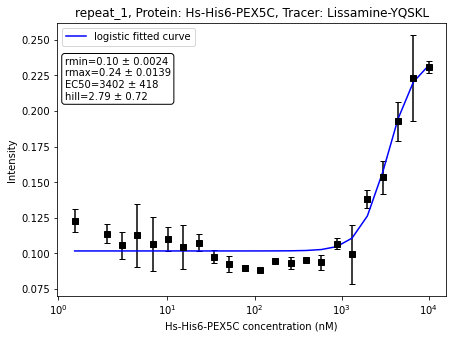

In [63]:
rep1.plot_ani(var='r', pair=('Hs-His6-PEX5C', 'Lissamine-YQSKL'))

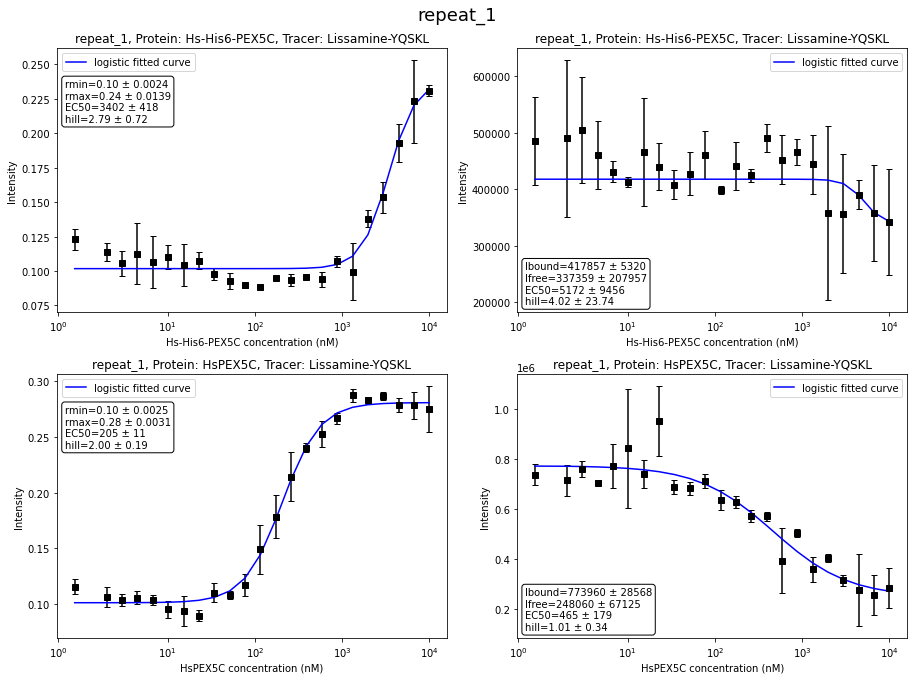

In [64]:
rep1.plot_ani_all()

In [67]:
my_data1.background_correct()
my_data1.calculate_r_i(plot_i=False)
my_data1.calc_data_to_fit()
my_data1.logistic_fit_all()

Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!



<ipython-input-66-e88ca2846d69>:243: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))   # calculate the error of the fitting params


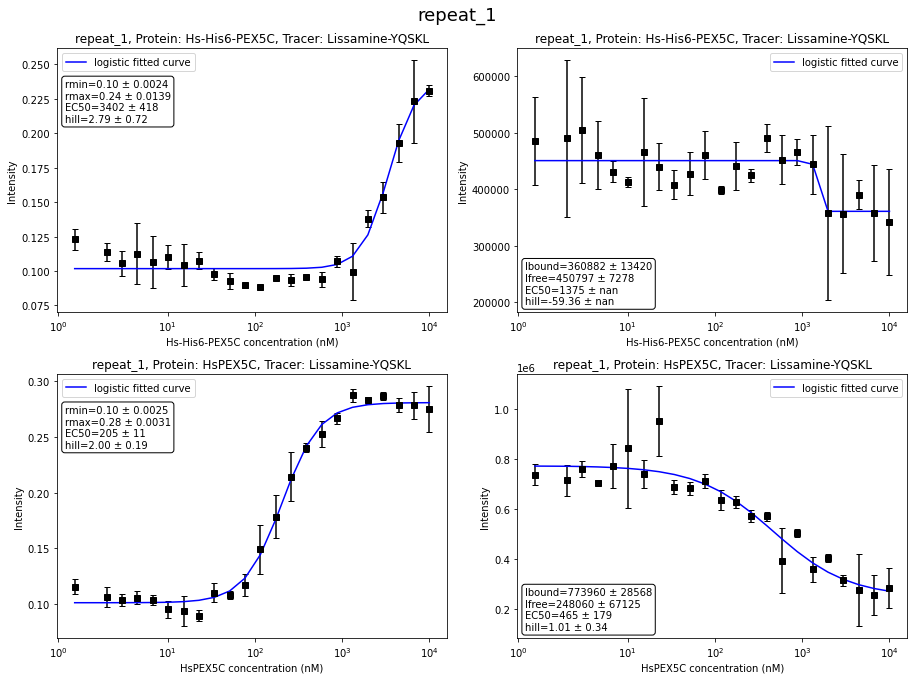

In [68]:
my_data1.plot_ani_all()

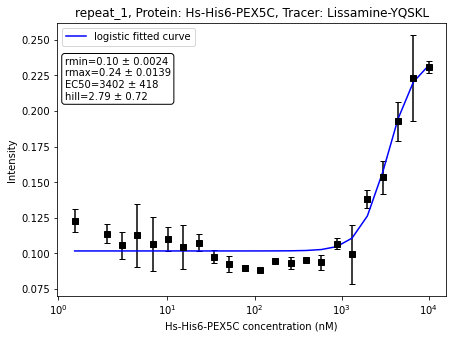

In [69]:
my_data1.plot_ani(rep='repeat_1', var='r', pair=('Hs-His6-PEX5C', 'Lissamine-YQSKL'))

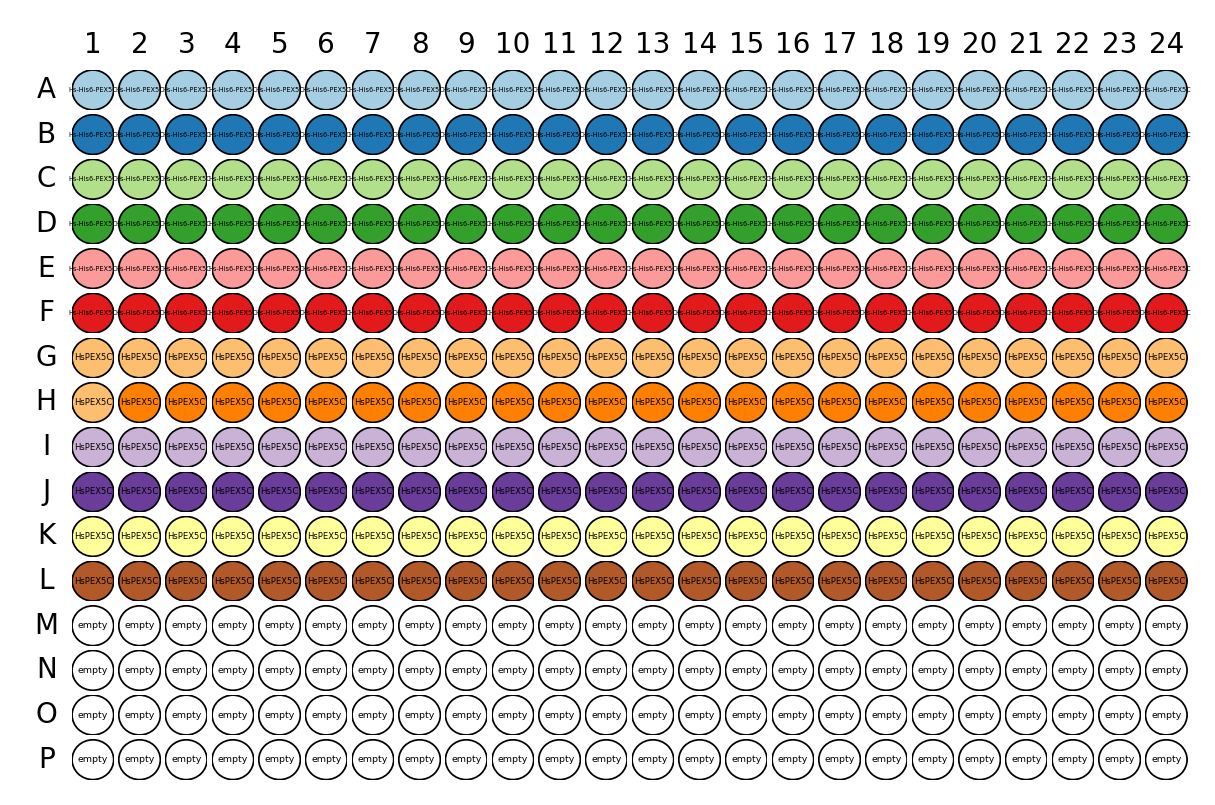

In [70]:
rep1.visualise(labelby='Protein Name', colorby='r_raw')